<h1>Fraud Detection w/ TFDF</h1>

@syahrulmwijaya <br>
first thing to do is importing all necessary things such as library as well as the dataset

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold
from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow_decision_forests as tfdf

import warnings
warnings.filterwarnings('ignore')

In [98]:
df = pd.read_csv("../input/fraud-detection/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h1>Simple Exploration</h1>

check dataset shape

In [99]:
df.shape

(284807, 31)

this part needed so it will be easier to understand the data

In [100]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [102]:
count_class = df['Class'].value_counts()
count_0, count_1 = df['Class'].value_counts()
print(f"total value : \n              class 0 : {count_0} is {100*count_0/(count_0+count_1) :.2f}% of total data \n              class 1 : {count_1} is {100*count_1/(count_0+count_1) :.2f}% of total data")

total value : 
              class 0 : 284315 is 99.83% of total data 
              class 1 : 492 is 0.17% of total data


<Axes: ylabel='Class'>

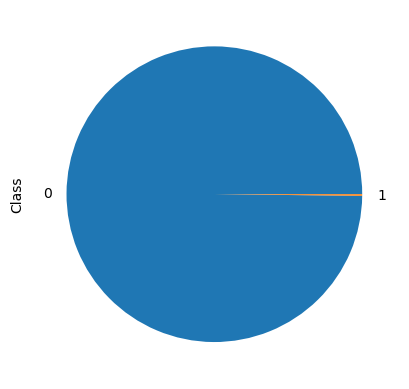

In [103]:
count_class.plot(kind='pie')

<h1>KFold</h1>

K-fold cross-validation is useful for various purposes, such as model selection, hyperparameter tuning, and estimating the model's performance on unseen data. It helps in obtaining a more reliable estimate of how the model will perform on new, unseen data and provides insights into its generalization capabilities.

In [104]:
folding = KFold(5)

<h1>Data Preparation</h1>

First make sure that there is no duplicated rows in dataset 

In [105]:
duplicate_rows = df[df.duplicated()]
print(f"there is total {len(duplicate_rows)} duplicated rows")

there is total 1081 duplicated rows


then drop all the duplicated rows

In [106]:
df.drop_duplicates(inplace=True)
df.shape

(283726, 31)

<h1>Class Weighting</h1>

since we knew that the classes in datasets is not balance (inclined to the 0 value), so we have to balance the class in order to get non-biased model

In [107]:
classes = np.unique(df['Class'])
sklearn_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y=df['Class'])
sklearn_weights = {k: v for k, v in zip(classes, sklearn_weights)}
print(f"weight for each class : \n     {sklearn_weights}")

weight for each class : 
     {0: 0.5008349426131409, 1: 299.9217758985201}


<h1>Dataset Splitting</h1>

Data preparation is kinda most important of doing "data thing" <br> 
in this data preparation the data will split into two difference data since we have only one dataset, which are train data and test data <br>
and to make it not generic, we will make the data picked to be the test data will be randomized

In [108]:
total_test = 100
test_row = []
random.seed(1604)
for i in tqdm(range(total_test)):
    test_row.append(random.randint(1, len(df)))

test = df.iloc[test_row].reset_index(drop=True)
train = df.drop(test_row).reset_index(drop=True)
test

  0%|          | 0/100 [00:00<?, ?it/s]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,22289.0,0.891615,-0.069797,1.160988,2.769679,-0.201457,1.203824,-0.525233,0.202855,1.332341,...,-0.177143,-0.333928,-0.140844,-0.813638,0.287887,-0.016154,0.011243,0.041603,131.41,0
1,87720.0,2.006189,-0.503081,-0.367749,0.080419,-0.364556,0.344135,-0.821607,0.084617,1.216539,...,-0.019166,0.082507,0.242867,0.088407,-0.449534,0.467569,-0.015560,-0.033137,26.50,0
2,151621.0,0.089209,0.358153,0.873051,-0.739417,0.131468,-0.119233,0.565791,-0.229283,1.105737,...,0.280522,1.122092,-0.314841,-0.646478,-0.163564,-0.530984,-0.153114,-0.179989,34.00,0
3,117592.0,1.824919,0.342348,-1.113910,3.544241,0.892810,0.575429,0.325765,0.012159,-1.154740,...,-0.207519,-0.723306,0.101993,-1.097433,-0.066946,-0.228259,-0.056014,-0.054871,72.90,0
4,73054.0,1.199169,0.169248,0.371965,0.643708,-0.587581,-0.911793,-0.146366,0.042205,0.056797,...,-0.245641,-0.840694,0.166342,0.441541,0.092605,0.071027,-0.039333,0.018343,0.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,148819.0,2.170408,-1.653827,-0.565492,-1.496890,-1.765531,-0.677099,-1.406860,-0.001006,-1.067420,...,-0.085976,0.110255,0.252068,0.016777,-0.389352,-0.199403,0.007395,-0.051836,44.80,0
96,154431.0,2.063120,-0.058896,-1.063312,0.419454,-0.161770,-1.223186,0.172994,-0.326309,0.565206,...,-0.291006,-0.710108,0.343945,0.041895,-0.304684,0.196004,-0.071614,-0.060330,0.99,0
97,52977.0,-1.923926,0.214791,1.128066,-1.763880,-1.060907,0.443400,-0.023925,-0.638810,-1.334849,...,0.111208,-1.685879,-0.081269,-0.315219,-0.434473,1.055461,-0.703059,-0.221427,135.00,0
98,163675.0,-1.035585,0.882938,1.499473,-0.386286,-0.249060,-0.193048,0.483221,-0.262033,0.369129,...,0.303196,1.004034,-0.214739,0.081399,-0.097366,0.647877,-0.529474,0.145466,35.90,0


In [109]:
len(train)

283626

<h1>Feature Engineering</h1>

Feature engineering is the most important step in data processing beside modelling, in short, feature engineering is a process where we select which correspondent feature we should take to make the model more efficient <br>
but since the data has all important columns so all columns will be used


In [110]:
feature_used =  [feature for feature in df.columns]
label = 'Class'

<h1>Change data format into tensorflow datasets format</h1>

tensorflow worked under unique data encoding but but it's easy to chage pandas dataset into tensorflow format dataset

In [111]:
#sample_ds = 

<h1>Modelling</h1>

before going too far into data modelling, check all the available model in the library

In [112]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

the model that will be used in this notebook is the "Gradient Boosted Model" with reason to use is :
<ol>
  <li>Performance: Gradient Boosted Models often provide excellent predictive performance, particularly when dealing with complex and non-linear relationships within the data. They are known for their ability to capture intricate patterns and handle high-dimensional feature spaces.
</li>
  <li>Robustness to Outliers: Gradient Boosted Models can be robust to outliers and noise in the data. The boosting process, which combines multiple weak models, can help mitigate the impact of outliers and focus on the majority patterns in the data.
</li>
  <li>Feature Importance: These models can provide insights into feature importance, allowing you to understand which features have the most significant impact on the predictions. This information can be valuable for feature selection, feature engineering, and understanding the underlying data relationships.
</li>
    <li>Flexibility: Gradient Boosted Models can handle a variety of data types, including numerical and categorical features. They can also handle missing data by imputing or excluding the missing values during training.</li>
</ol>

In [113]:
model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmp4cw3jmwq as temporary training directory


[WARNING 23-07-18 13:06:49.3264 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-18 13:06:49.3264 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-18 13:06:49.3264 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [114]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283621,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
283622,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
283623,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
283624,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


<h1>Train with Cross Validation</h1>

First make an empty dataset to store the validation value

In [115]:
oof = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)

In [116]:
oof.iloc[28362]

0    0.0
Name: 28362, dtype: float64

then make an empty dictionaty to store the models for each fold

In [117]:
models = {}

last but not least, make an empty dictionary to save the metrics of trained model

In [118]:
accuracy = {}
cross_entropy = {}

In [119]:
for i, (train_index, valid_index) in tqdm(enumerate(folding.split(X=train)), total=total_iterations):
    print(valid_index)

  0%|          | 0/5 [00:00<?, ?it/s]

[    0     1     2 ... 56723 56724 56725]
[ 56726  56727  56728 ... 113448 113449 113450]
[113451 113452 113453 ... 170173 170174 170175]
[170176 170177 170178 ... 226898 226899 226900]
[226901 226902 226903 ... 283623 283624 283625]


In [120]:
len(train)

283626

In [121]:
valid_rows.index.values

array([226901, 226902, 226903, ..., 283623, 283624, 283625])

In [122]:
total_iterations = folding.get_n_splits()
for i, (train_index, valid_index) in tqdm(enumerate(folding.split(X=train)), total=total_iterations):
    
    train_rows = train[feature_used].iloc[train_index]
    valid_rows = train[feature_used].iloc[valid_index]
    
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_rows, label=label)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_rows, label=label)
    
    model.compile(metrics=["accuracy", "binary_crossentropy"]) 
    
    model.fit(x=train_ds, class_weight=sklearn_weights)
    
    models[f'type_{i}'] = model
    
    validation = model.predict(valid_ds)
    
    #calculating error
    oof.iloc[valid_rows.index.values, 0] = validation.flatten() 
    evaluation = model.evaluate(x=valid_ds,return_dict=True)
    
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

  0%|          | 0/5 [00:00<?, ?it/s]

Reading training dataset...
Training dataset read in 0:00:06.518184. Found 226900 examples.
Training model...
Model trained in 0:01:37.902760
Compiling model...


[INFO 23-07-18 13:08:34.3357 UTC kernel.cc:1243] Loading model from path /tmp/tmp4cw3jmwq/model/ with prefix df0e6cb393df46ef
[INFO 23-07-18 13:08:34.3442 UTC decision_forest.cc:660] Model loaded with 26 root(s), 1586 node(s), and 30 input feature(s).
[INFO 23-07-18 13:08:34.3443 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-18 13:08:34.3443 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
57/57 [==============================] - 2s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9955 - binary_crossentropy: 0.0765
Reading training dataset...
Training dataset read in 0:00:06.038867. Found 226901 examples.
Training model...


[INFO 23-07-18 13:09:24.6589 UTC decision_forest.cc:660] Model loaded with 56 root(s), 3416 node(s), and 30 input feature(s).


Model trained in 0:00:02.995179
Compiling model...


[INFO 23-07-18 13:09:27.4365 UTC kernel.cc:1243] Loading model from path /tmp/tmp4cw3jmwq/model/ with prefix df0e6cb393df46ef
[INFO 23-07-18 13:09:27.4450 UTC decision_forest.cc:660] Model loaded with 26 root(s), 1586 node(s), and 30 input feature(s).
[INFO 23-07-18 13:09:27.4451 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-18 13:09:27.4451 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
57/57 [==============================] - 2s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9987 - binary_crossentropy: 0.0603
Reading training dataset...
Training dataset read in 0:00:05.946364. Found 226901 examples.
Training model...


[INFO 23-07-18 13:09:38.7858 UTC decision_forest.cc:660] Model loaded with 57 root(s), 3477 node(s), and 30 input feature(s).


Model trained in 0:00:03.013692
Compiling model...


[INFO 23-07-18 13:09:41.5714 UTC kernel.cc:1243] Loading model from path /tmp/tmp4cw3jmwq/model/ with prefix df0e6cb393df46ef
[INFO 23-07-18 13:09:41.5801 UTC decision_forest.cc:660] Model loaded with 26 root(s), 1586 node(s), and 30 input feature(s).
[INFO 23-07-18 13:09:41.5802 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-18 13:09:41.5802 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
57/57 [==============================] - 2s 25ms/step - loss: 0.0000e+00 - accuracy: 0.9976 - binary_crossentropy: 0.0560
Reading training dataset...
Training dataset read in 0:00:06.058256. Found 226901 examples.
Training model...


[INFO 23-07-18 13:09:51.8654 UTC decision_forest.cc:660] Model loaded with 58 root(s), 3538 node(s), and 30 input feature(s).


Model trained in 0:00:03.139946
Compiling model...


[INFO 23-07-18 13:09:54.7758 UTC kernel.cc:1243] Loading model from path /tmp/tmp4cw3jmwq/model/ with prefix df0e6cb393df46ef
[INFO 23-07-18 13:09:54.7845 UTC decision_forest.cc:660] Model loaded with 26 root(s), 1586 node(s), and 30 input feature(s).
[INFO 23-07-18 13:09:54.7845 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-18 13:09:54.7846 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
57/57 [==============================] - 2s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9971 - binary_crossentropy: 0.0572
Reading training dataset...
Training dataset read in 0:00:06.675976. Found 226901 examples.
Training model...


[INFO 23-07-18 13:10:06.7465 UTC decision_forest.cc:660] Model loaded with 59 root(s), 3599 node(s), and 30 input feature(s).


Model trained in 0:00:03.144624
Compiling model...


[INFO 23-07-18 13:10:09.6557 UTC kernel.cc:1243] Loading model from path /tmp/tmp4cw3jmwq/model/ with prefix df0e6cb393df46ef
[INFO 23-07-18 13:10:09.6648 UTC decision_forest.cc:660] Model loaded with 26 root(s), 1586 node(s), and 30 input feature(s).
[INFO 23-07-18 13:10:09.6650 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-18 13:10:09.6650 UTC kernel.cc:1075] Use fast generic engine


Model compiled.
57/57 [==============================] - 2s 30ms/step - loss: 0.0000e+00 - accuracy: 0.9977 - binary_crossentropy: 0.0543


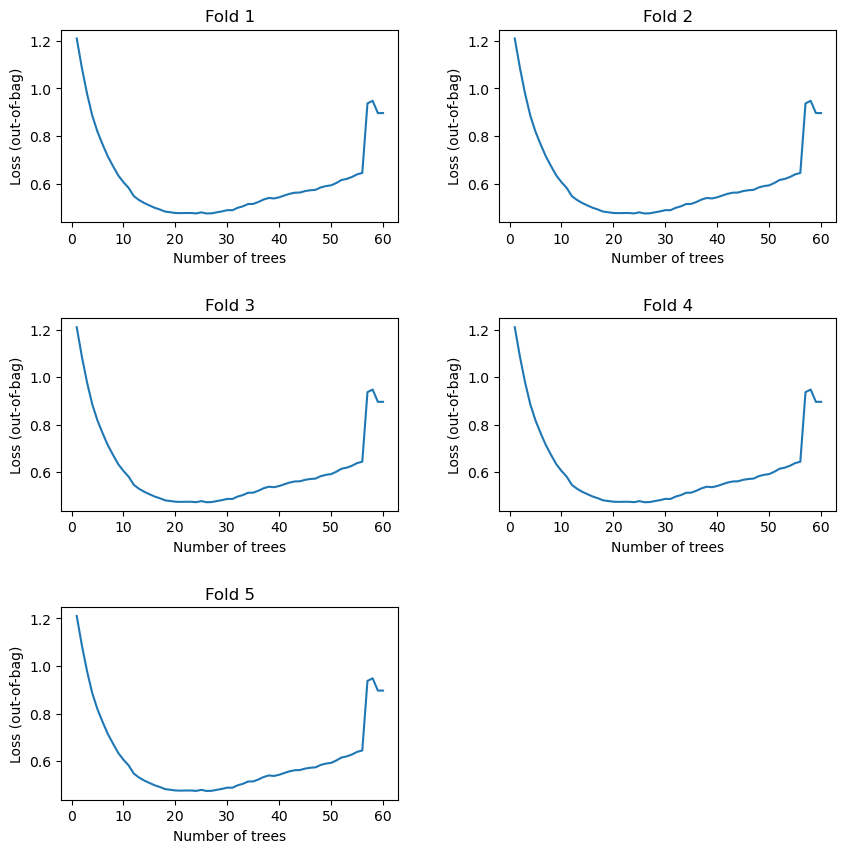

In [123]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')
    
axis[2][1].set_visible(False)
plt.show()

<h1>Testing Phase</h1>

after some training, now the model is ready to be tested to the test dataset

In [124]:
key = pd.DataFrame({'Class' : test['Class']})

check models name

In [125]:
models

{'type_0': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7ff5a19f2ec0>,
 'type_1': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7ff5a19f2ec0>,
 'type_2': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7ff5a19f2ec0>,
 'type_3': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7ff5a19f2ec0>,
 'type_4': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7ff5a19f2ec0>}

prediction time

In [126]:
test_model = test.drop(columns='Class')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_model)
predictions = models['type_4'].predict(test_ds)

1/1 [==============================] - 0s 99ms/step


reconstruct the prediction file so it will be comparable with the actual value from "key"

In [130]:
predictions_model = []
for prediction in predictions:
    predictions_model.append(int(np.round(prediction)))
predictions_df = pd.DataFrame({'Class' : predictions_model})

make a simple scoring metric

In [131]:
def evaluating(truth, pred):
    score = 0
    for i in range(len(truth)):
        if np.all(pred.iloc[i] == truth.iloc[i]):
            score +=1
    return score

scoring 

In [132]:
score = evaluating(key, predictions_df)
print(f"the score is {score}")

the score is 100


from the test phase we can see that the model gives high score, that also means our tree model can give good prediction

<h1>Feature Importance</h1>

In [133]:
inspector = models['type_4'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


In [145]:
important_features = inspector.variable_importances()['NUM_AS_ROOT']
tuplecoy = tuple(important_features)
important_feature = []
for item in tuplecoy:
    important_feature.append([item[0][0] , item[1]])
important_df = pd.DataFrame(important_feature, columns=['feature', 'score'])
important_df.head(100)

,feature,score
0,V14,14.0
1,V10,7.0
2,V12,4.0
3,Amount,1.0


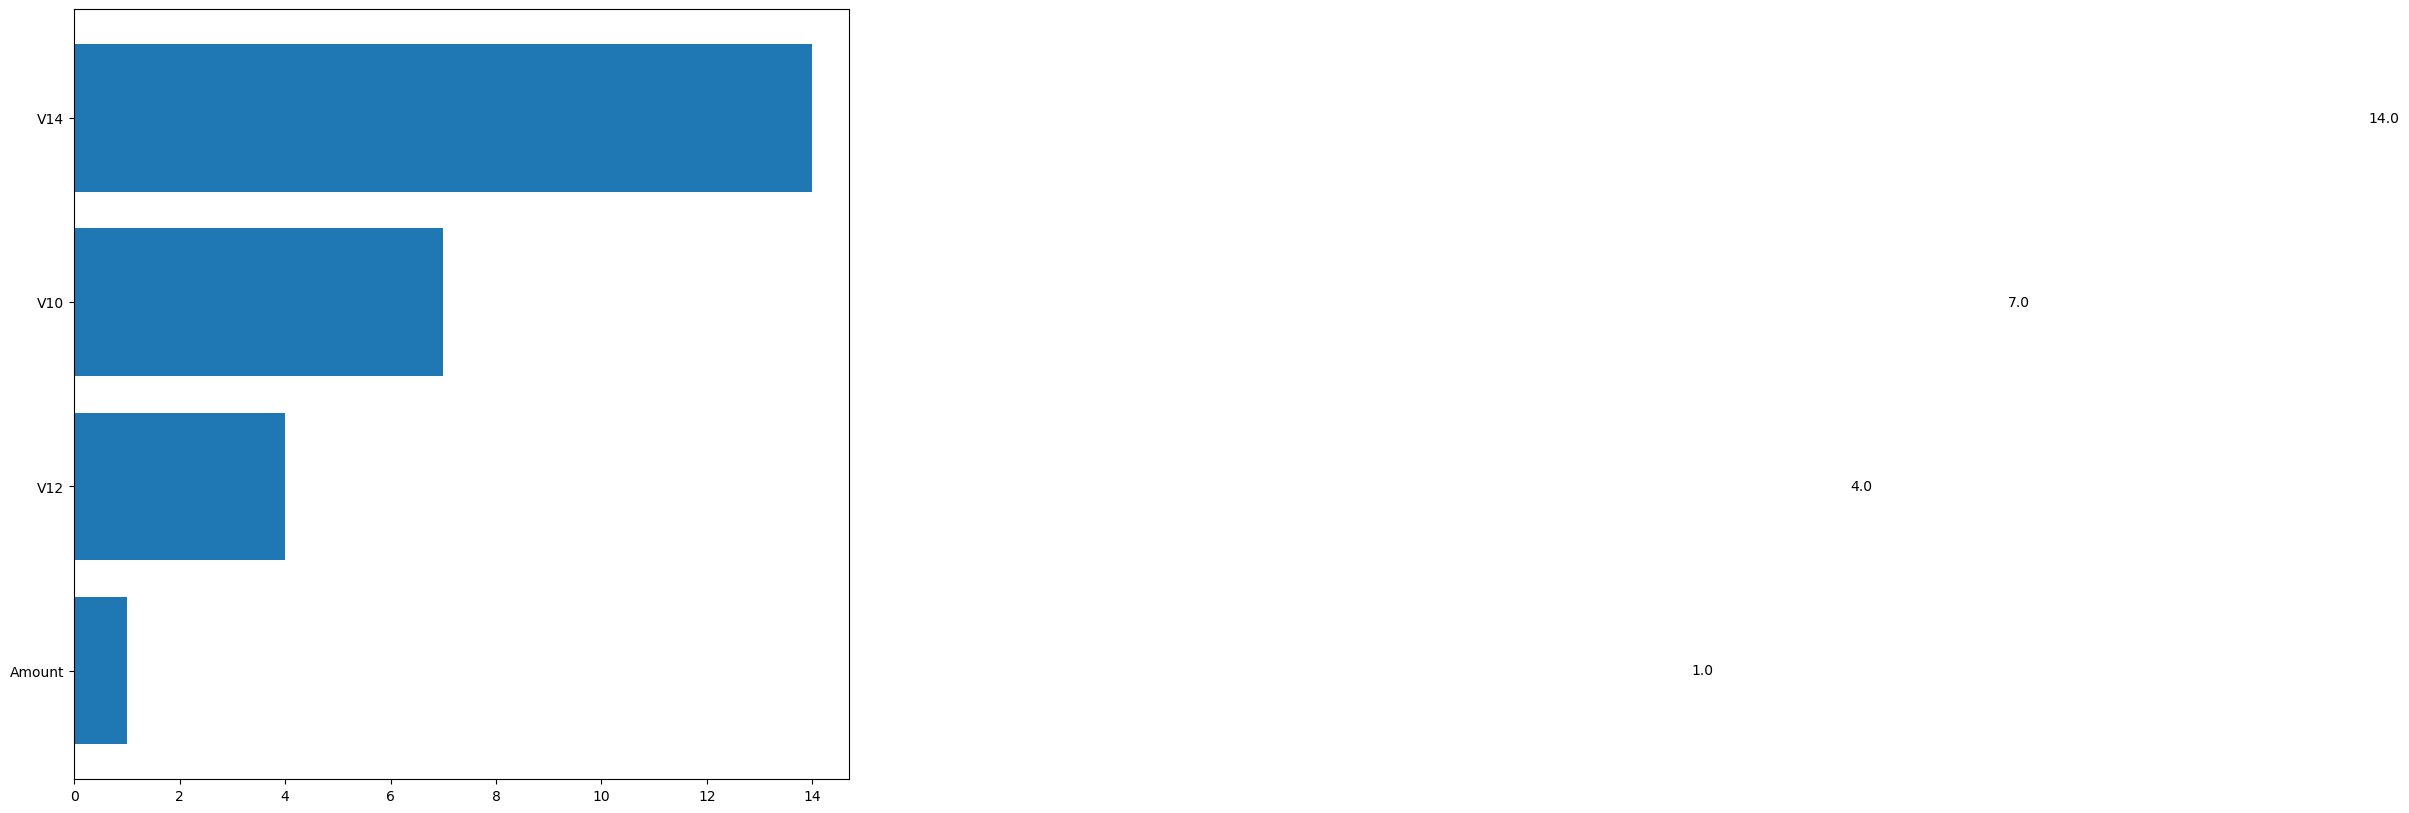

In [146]:
important_sorted = important_df.sort_values('score', ascending=True)
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(important_sorted['feature'],important_sorted['score'])
for i, v in enumerate(important_sorted['score']):
    plt.text(v+30.1, i, str(v), color='black', ha='right', va='center')

From the plot above we can see that V14 is the most important feature provided in the dataset

<h1>Conclusion</h1>

we can see from the simulation above that a decision trees model can gives a good prediction or classification since it's robustness on outlier, feature interactions, and also non-linearity